#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).


<a id='К-содержанию'></a>
**Содержание проекта** \
[Подготовка данных](#Подготовка-данных)\
[Анализ](#Анализ)\
[Обучение](#Обучение)\
[Тестирование](#Тестирование)\
[Общий вывод](#Общий-вывод)\
[Чек-лист_проверки](#Чек-лист-проверки)

In [1]:
%%capture
!pip install sweetviz
!pip install numpy==1.26.4
!pip install matplotlib==3.8.4
!pip install catboost
!pip install --upgrade scikit-learn seaborn

In [2]:
#импортируем библиотеки перед началом проекта одним блоком
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy import stats as st
import sweetviz as sv

# исследование и анализ временного ряда + визуализация
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import sweetviz as sv

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.model_selection import train_test_split, TimeSeriesSplit

# импортируем классы GridSearchCV
from sklearn.model_selection import GridSearchCV

# загружаем нужные модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.dummy import DummyRegressor

# загружаем функции для работы с метриками
from sklearn.metrics import mean_squared_error


In [3]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [4]:
# функция добавления признаков, 
# данные года и месяца не включены: год один для всего периода, нет смысла добавлять этот признак, 
# а месяцы не все присутствуют в ряде и обучение на данныз за одни месяцы при тесте на других 
# даст неверное прогнозирование модели
    
def make_features(data, max_lag, rolling_mean_size, column):
    data_mf = data.copy()
    data_mf['day'] = data_mf.index.day
    data_mf['dayofweek'] = data_mf.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_mf['lag_{}'.format(lag)] = data_mf[column].shift(lag)

    data_mf['rolling_mean'] = data_mf[column].shift().rolling(rolling_mean_size).mean()
    return data_mf

<a id='Подготовка-данных'></a> 
## Подготовка данных
[К содержанию](#К-содержанию) 

In [5]:
# импортируем данные
pth1 = '/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_12_Taxi/taxi.csv'
pth2 = '/datasets/taxi.csv'

if os.path.exists(pth1):
    taxi = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    taxi = pd.read_csv(pth2,index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')


In [6]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
# приведем данные в хронологический порядок и проверим
taxi = taxi.sort_index()
taxi.index.is_monotonic_increasing

True

In [8]:
# проверим данные на пропуски
print('Количество пропусков в датасете: ', taxi.isna()['num_orders'].sum())

Количество пропусков в датасете:  0


In [9]:
# проверим данные на дубликаты в индекске, в самом ряду дубликаты есть, т.к. это просто кличество заказаов в конкретный час
print('Количество дубликатов в индлексе: ', taxi.index.duplicated(keep=False).sum())


Количество дубликатов в индлексе:  0


In [10]:
# данные в датасете представлены по 10-минутным периодам, ресемплируем их в часовые данные
taxi_h = taxi.resample('1h').sum()
taxi_h.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [11]:
display(taxi_h.info())
display(taxi_h.describe())
print('Начало периода: ',taxi_h.index[0])
print('Конец периода: ',taxi_h.index[-1]);

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Начало периода:  2018-03-01 00:00:00
Конец периода:  2018-08-31 23:00:00


**Вывод**

после загрузки данные проверили на пропуски, дубликаты, хронологический порядок и ресемплировали данные в часовые промежутки. Данные в ряду представлены за период с 1 марта 2018 по 31 августа 2018. Количество заказов в час колеблется от 0 до 462, со средним 84 заказа, в дальнейшем нужно посмотреть распределение, выбросы и соответствующие статистики ряда.

<a id='Общий-вывод'></a> 
## Анализ
[К содержанию](#К-содержанию) 

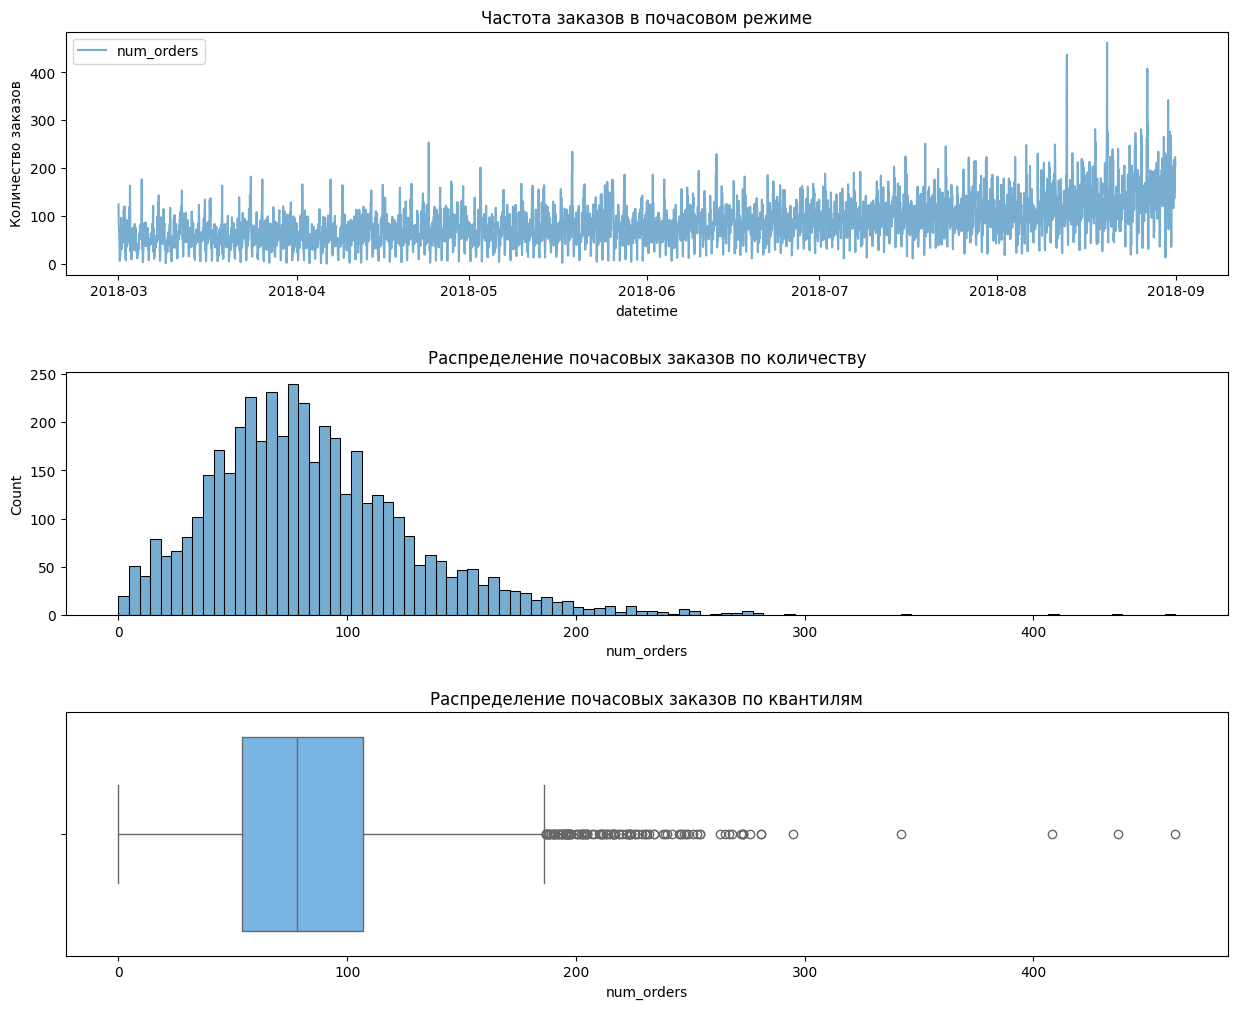

In [12]:
# посмотрим на графики распределения заказов
plt.subplots(3,1,figsize=(15, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.subplot(311)
sns.lineplot(data=taxi_h, alpha=0.6)
plt.title('Частота заказов в почасовом режиме')
plt.ylabel('Количество заказов')

plt.subplot(312)
sns.histplot(data=taxi_h, x='num_orders', bins=100,
                     alpha=0.6,
                     legend='auto');
plt.title('Распределение почасовых заказов по количеству')

plt.subplot(313)
sns.boxplot(data=taxi_h, x='num_orders', color=(0.404, 0.718, 0.957))
plt.title('Распределение почасовых заказов по квантилям')

plt.show()

In [13]:
# на графике несколько пиков, посмоотрим на них отдельно
taxi_h[taxi_h['num_orders']>300]

,num_orders
datetime,
2018-08-13 02:00:00,437
2018-08-20 02:00:00,462
2018-08-27 02:00:00,408
2018-08-30 17:00:00,342


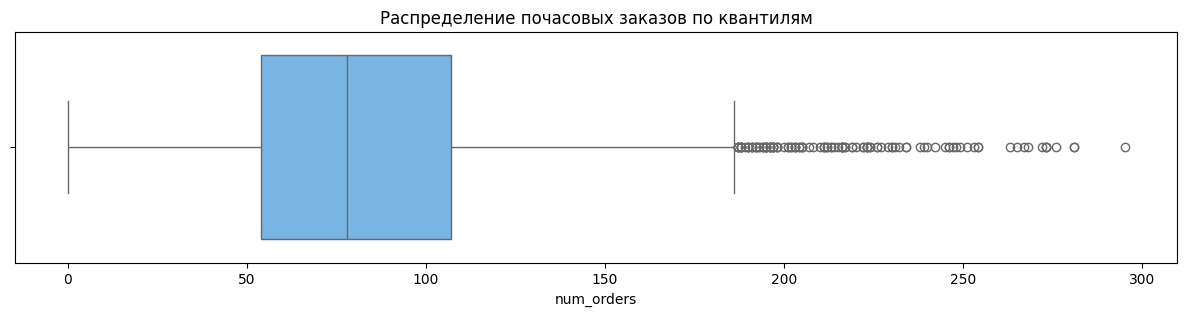

In [14]:
# несколько выбросов в один и тот же день недели в 2 часа ночи - 
# если бы не такой поздний час, можно было бы предположить окончание какого-либо мероприятия
# заменим 4 выброса на средние значения для этого часа по всему ряду
taxi_h.loc[taxi_h['num_orders']>400,'num_orders'] = int(taxi_h[taxi_h.index.hour == 2]['num_orders'].mean())
taxi_h.loc[taxi_h['num_orders']>300,'num_orders'] = int(taxi_h[taxi_h.index.hour == 17]['num_orders'].mean())


# проверим боксплот после изменения
plt.figure(figsize=(15, 3))
sns.boxplot(data=taxi_h, x='num_orders', color=(0.404, 0.718, 0.957))
plt.title('Распределение почасовых заказов по квантилям');

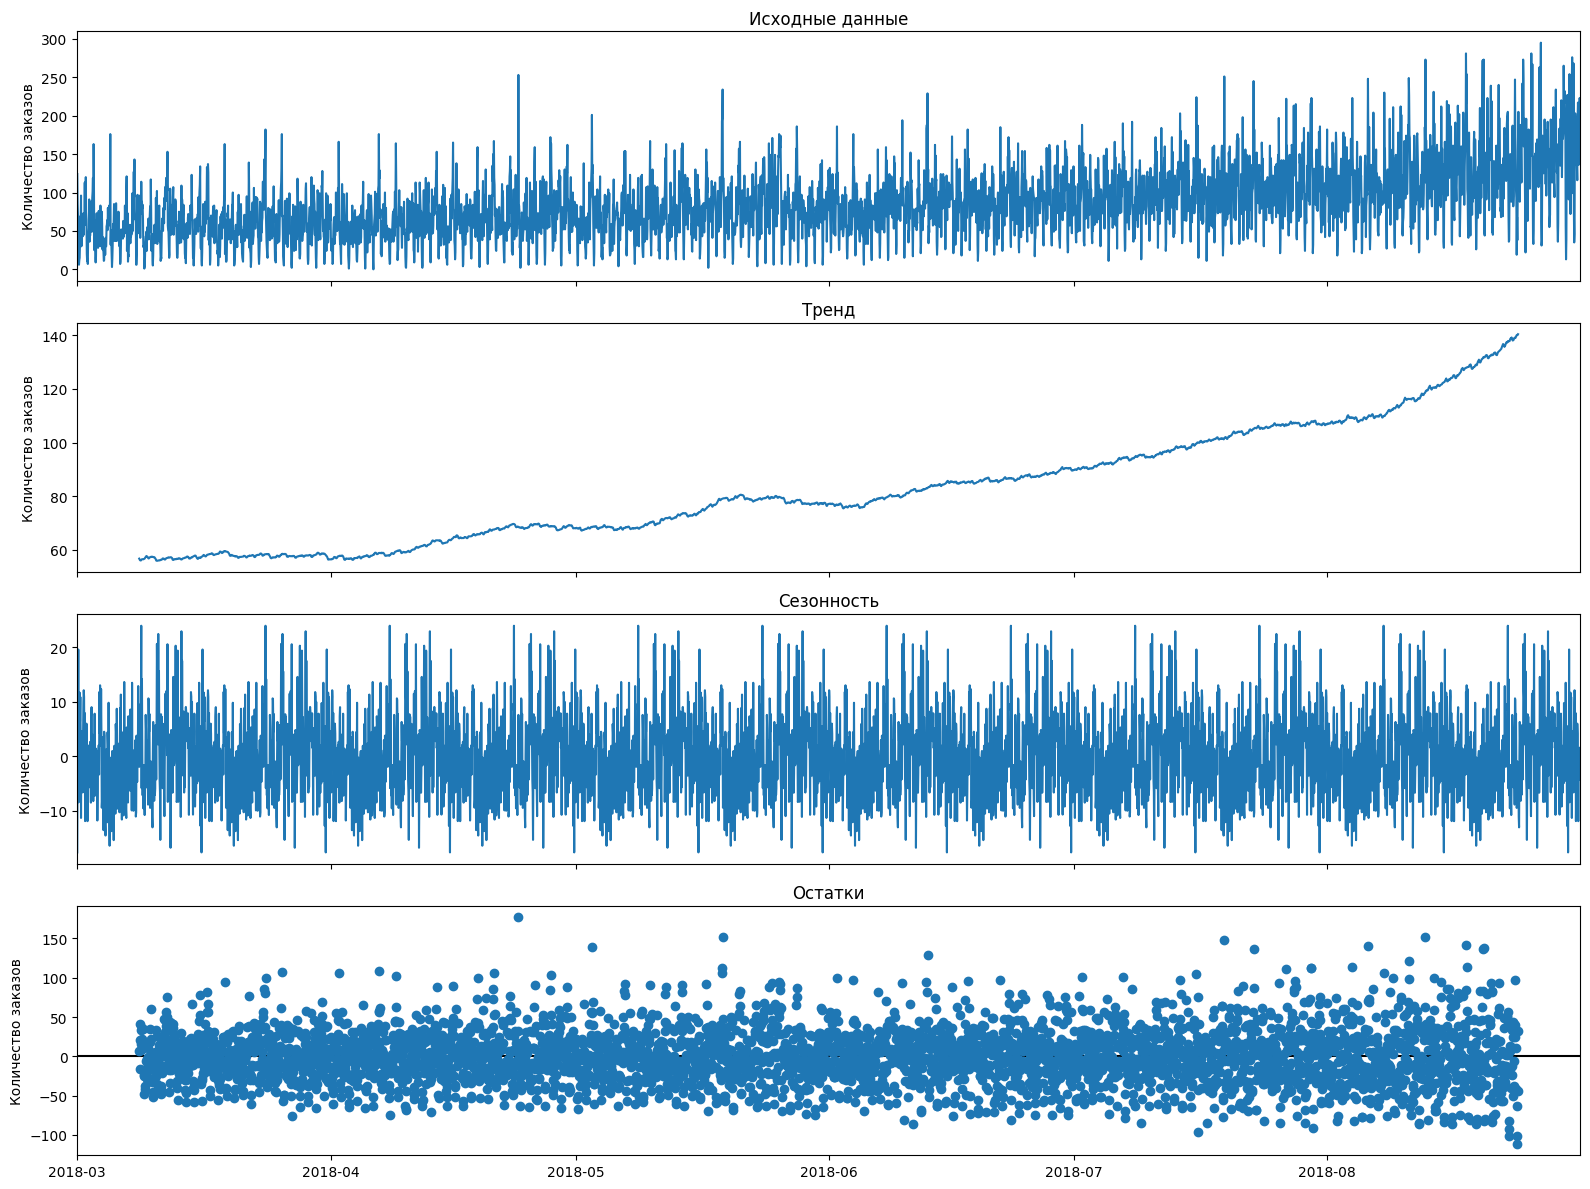

In [15]:
# выделим трендовую и сезонную составляющие, а также остатки
result = seasonal_decompose(taxi_h['num_orders'], model='additive', period = 365) # для наглядности скользящее среднее для тренда указали в 365 дней

# построение графиков
fig = result.plot()
fig.set_size_inches((16, 12))

fig.axes[0].set_title('Исходные данные')
fig.axes[0].set_ylabel('Количество заказов')

fig.axes[1].set_title('Тренд')
fig.axes[1].set_ylabel('Количество заказов')

fig.axes[2].set_title('Сезонность')
fig.axes[2].set_ylabel('Количество заказов')

fig.axes[3].set_title('Остатки')
fig.axes[3].set_ylabel('Количество заказов')

plt.tight_layout()
plt.show()

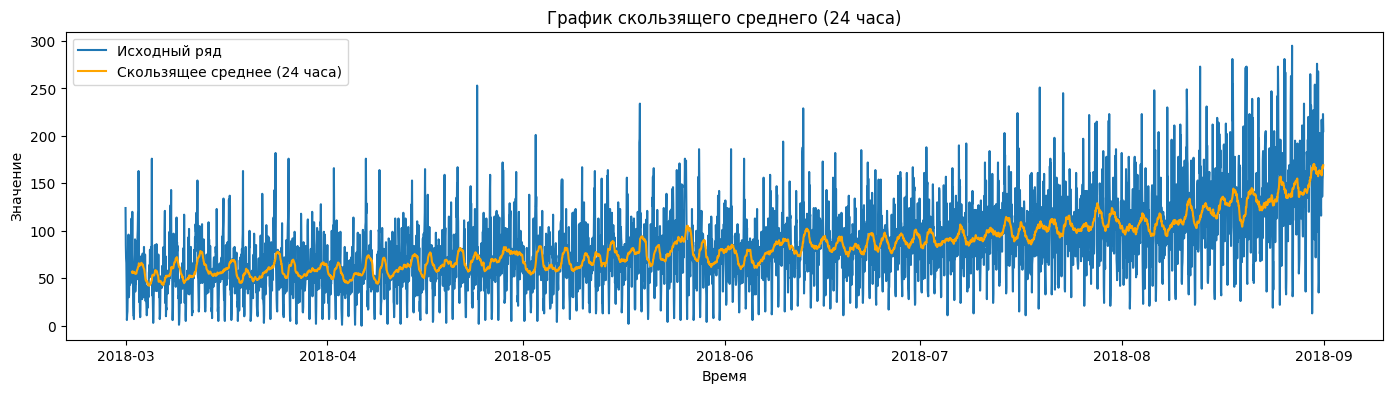

In [16]:
# построим график скользящего среднего с окном 24 часа для оценки стационарности

plt.figure(figsize=(17, 4))
plt.title('График скользящего среднего (24 часа)')

ma = taxi_h['num_orders'].shift().rolling(24).mean()

sns.lineplot(data=taxi_h['num_orders'], label='Исходный ряд')
sns.lineplot(data=ma, label='Скользящее среднее (24 часа)', color='orange')

plt.legend()
plt.xlabel('Время')
plt.ylabel('Значение')
plt.show()

Судя по графикам выше:
- временной ряд содержит и трендовую и сезонную составляющие, а также расширяющееся распределение значений,
- среднедневные значения количества заказов также растут со временем,  
поэтому скорее всего ряд нестационарный, проверим это дополнительно с помощью статистических тестов.

Сформируем гипотезы для обоих статтестов на стационарность:
- для ADF:
    * нулевая гипотеза: ряд имеет единичный корень (ряд не является стационарным)
    * альтернативная гипотеза: ряд не имеет единичного корня;  
а = 0.05, 0.01, если нулевую гипотезу не удалось отвергнуть, этот тест может свидетельствовать о нестационарности ряда.  

- для KPSS гипотезы обратные:
    * нулевая гипотеза: процесс является стационарным
    * альтернативная гипотеза: ряд имеет единичный корень (ряд не является стационарным);  
а = 0.05, 0.01, если нулевую гипотезу не удалось отвергнуть, этот тест может свидетельствовать о стационарности ряда.

In [17]:
# проведем тест Дики-Фуллера (ADF)
adf_test(taxi_h['num_orders'])

Results of Dickey-Fuller Test:
Test Statistic                   -2.959966
p-value                           0.038806
#Lags Used                       30.000000
Number of Observations Used    4385.000000
Critical Value (1%)              -3.431842
Critical Value (5%)              -2.862199
Critical Value (10%)             -2.567121
dtype: float64


In [18]:
# проведем тест KPSS
kpss_test(taxi_h['num_orders'])

Results of KPSS Test:
Test Statistic           10.782385
p-value                   0.010000
Lags Used                33.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/var/folders/yf/tnhxwgts2035718d0nhj30rw0000gn/T/ipykernel_28365/2591240010.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


Вывод по **стационарности** - 
- по тесту ADF полученное значение p-value меньше заданного уровня значимости 0.05, что может свидетельствовать о стационарности ряда, при этом если ужесточить критерий значимости до 0.01, интерпретация поменятеся на противоположную и ряд можем характеризовать как нестационарный, получается имеем пограничное значение;
- по тесту KPSS полученное p-value меньше обоих стандартных порогов значимости, таким образом данный тест очевидно характеризует ряд как нестационарный;
- с учетом очевидного смещения скользящего среднего на графике выше, а также результатов теста, можем охарактеризовать ряд как нестационарный. 

In [19]:
# сгенерируем дополнительные признаки
taxi_h_af = make_features(taxi_h, 4, 8, 'num_orders')

taxi_h_af.head(10)


,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN
2018-03-01 05:00:00,6,1,3,43.0,66.0,71.0,85.0,NaN
2018-03-01 06:00:00,12,1,3,6.0,43.0,66.0,71.0,NaN
2018-03-01 07:00:00,15,1,3,12.0,6.0,43.0,66.0,NaN
2018-03-01 08:00:00,34,1,3,15.0,12.0,6.0,43.0,52.75


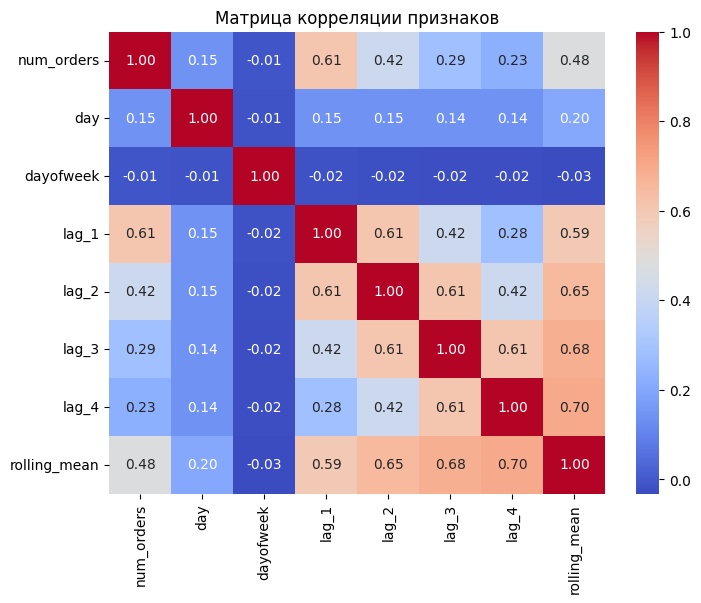

In [20]:
# построим матрицу корреляции между признаками привязанными ко временным параметрам и к предыдцщим значениям самого ряда 
correlation = taxi_h_af.corr(method='spearman')
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляции признаков')
plt.show();

In [21]:
# по таблице признак дня недели вообще не связан с целевым - исключим его
taxi_h_af = taxi_h_af.drop('dayofweek', axis=1)

# и удалим первые значения NaN, использованные для вычисления признаков
taxi_h_af = taxi_h_af.iloc[8:]

taxi_h_af.head()

,num_orders,day,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,
2018-03-01 08:00:00,34,1,15.0,12.0,6.0,43.0,52.750
2018-03-01 09:00:00,69,1,34.0,15.0,12.0,6.0,41.500
2018-03-01 10:00:00,64,1,69.0,34.0,15.0,12.0,39.500
2018-03-01 11:00:00,96,1,64.0,69.0,34.0,15.0,38.625
2018-03-01 12:00:00,30,1,96.0,64.0,69.0,34.0,42.375


In [22]:
# для сравнения приведем анализ итоговой таблицы признаков с помощью пакета SweetViz
report = sv.analyze([taxi_h_af, "TS-report"])

                                             |          | [  0%]   00:00 -> (? left)


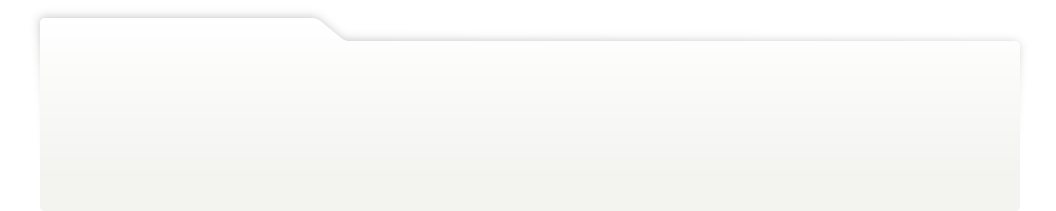
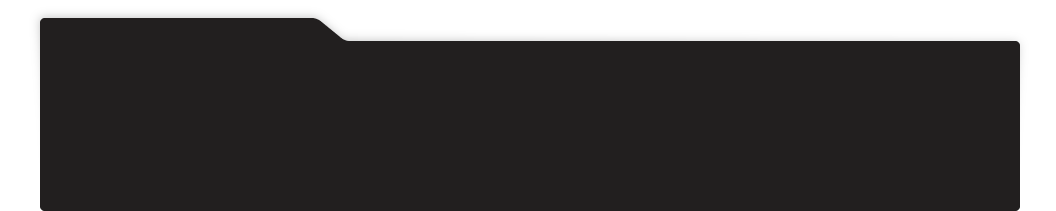
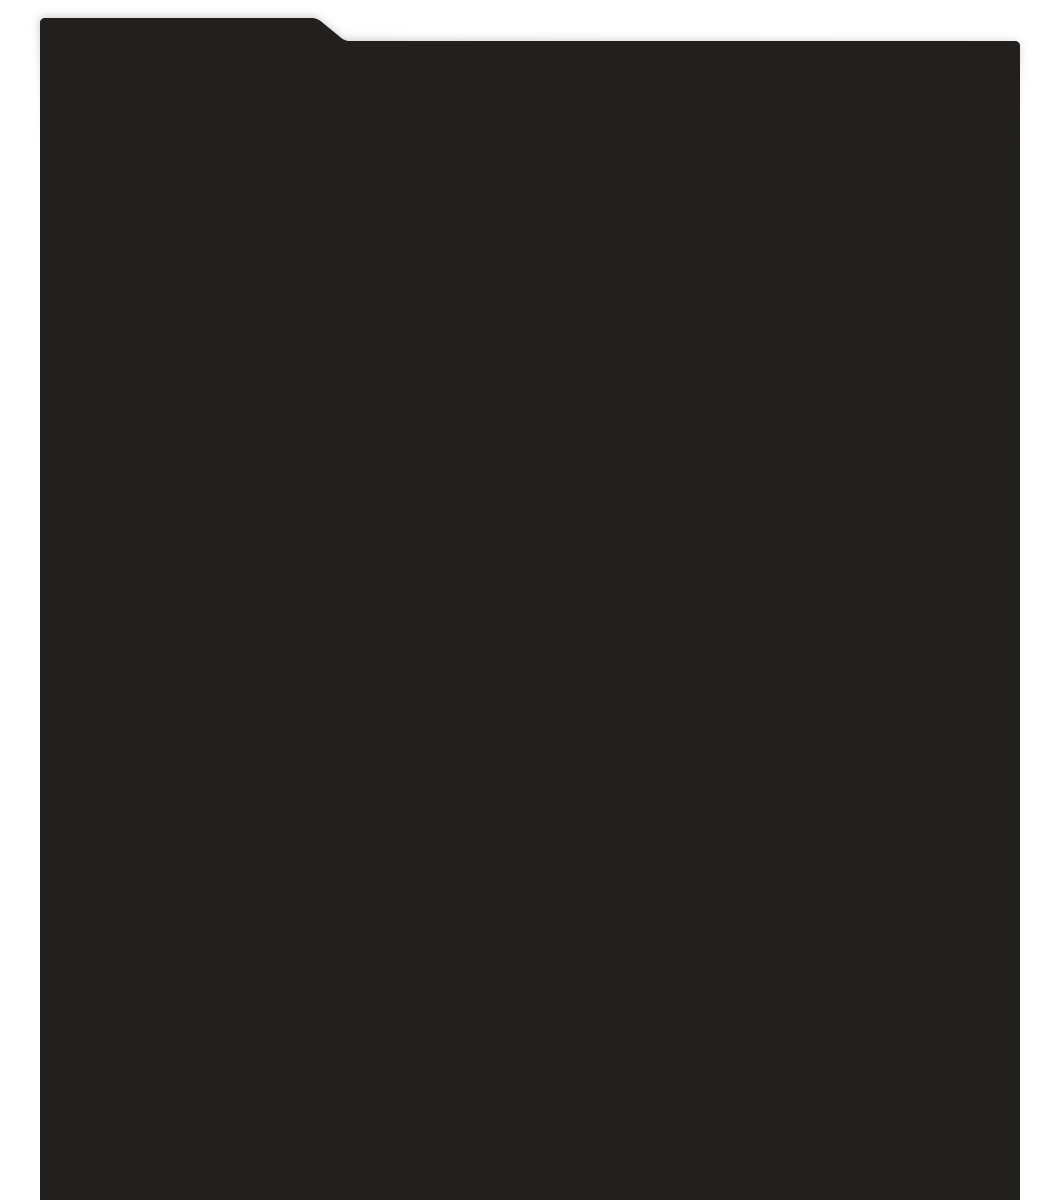
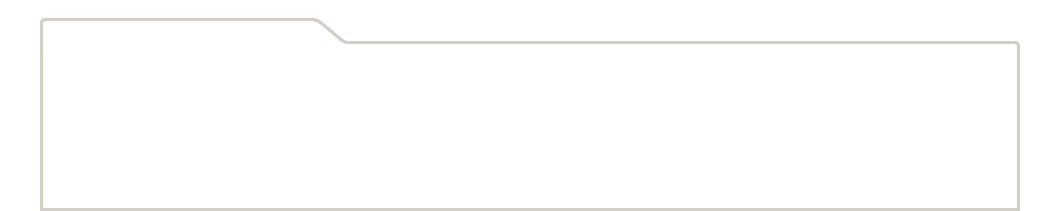
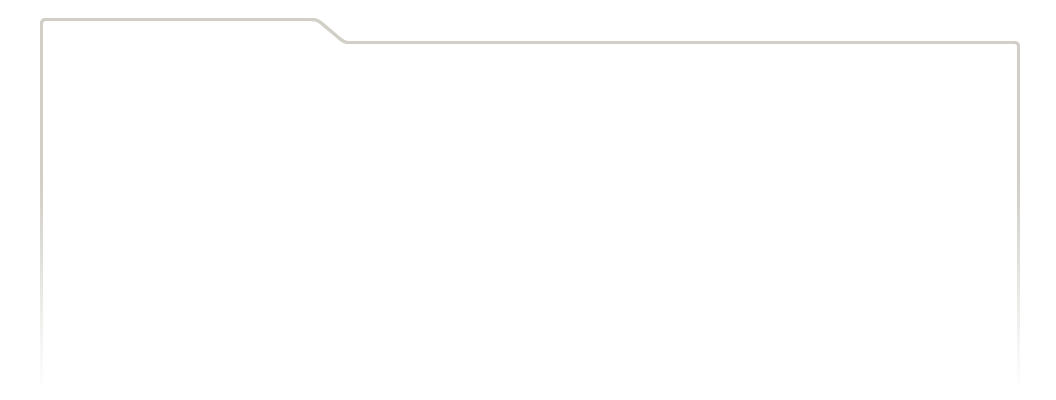
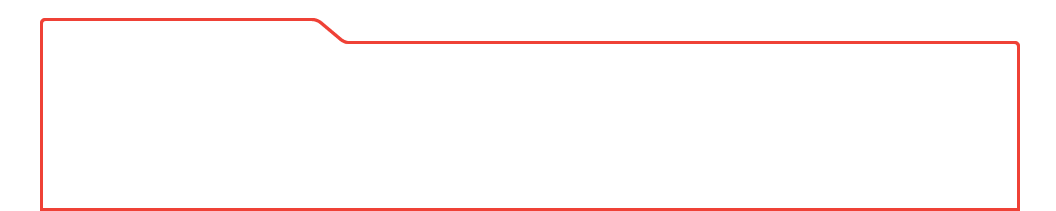
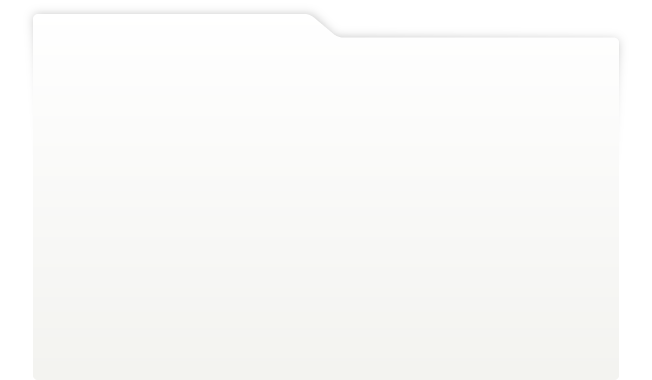
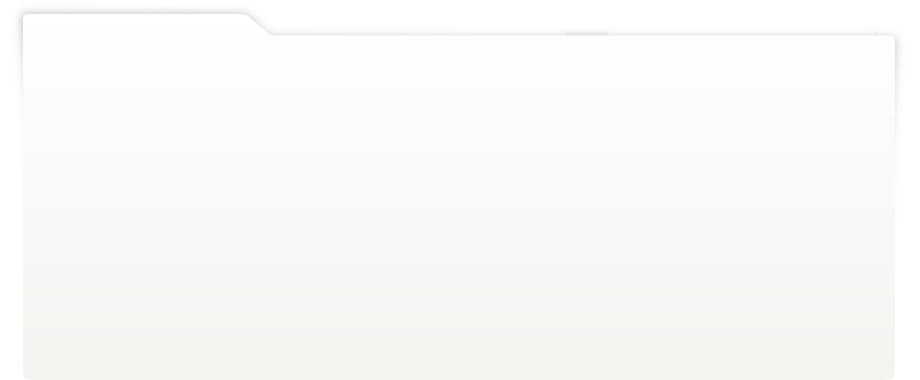
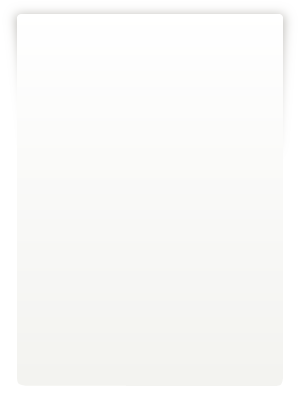
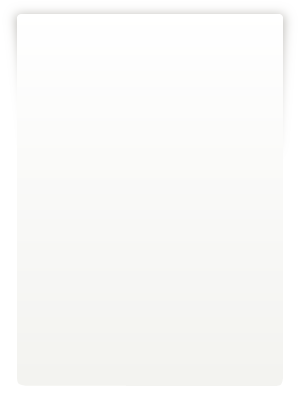
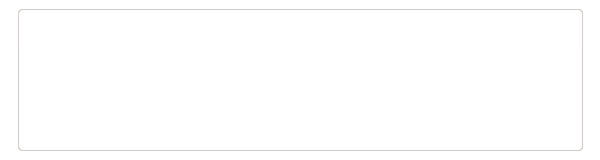
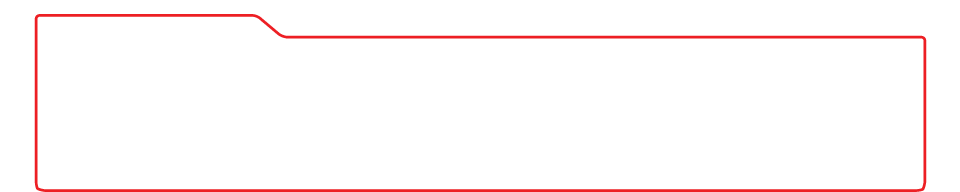
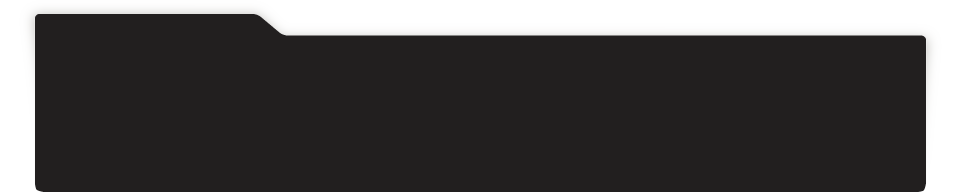
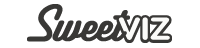
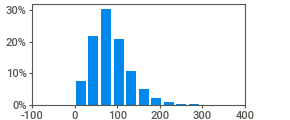
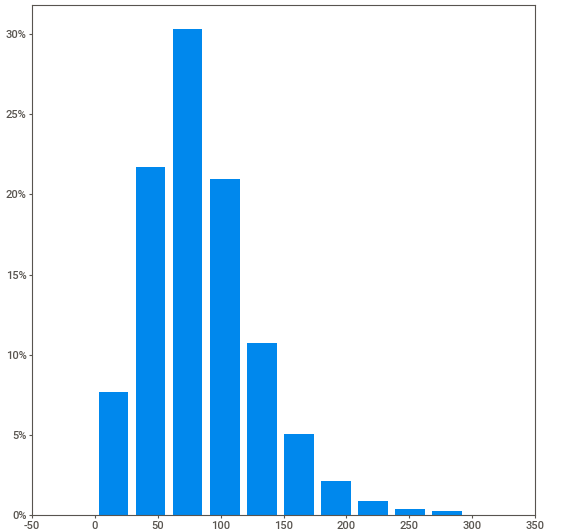
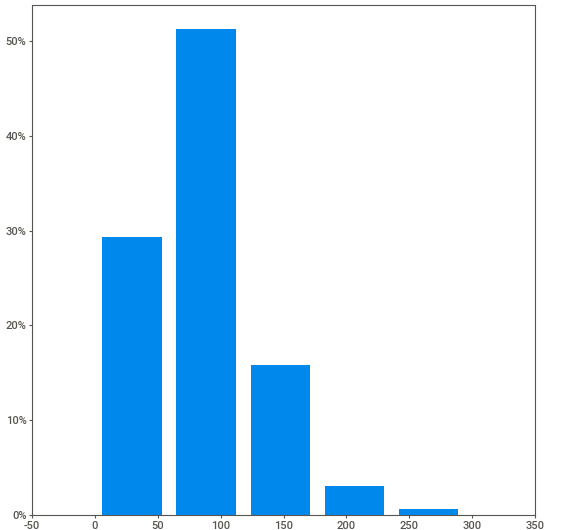
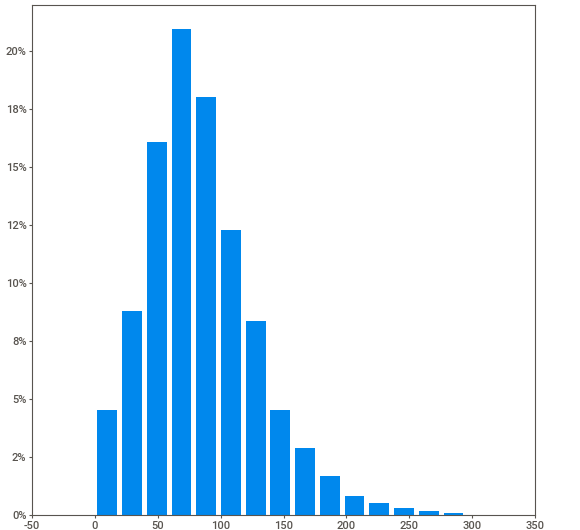
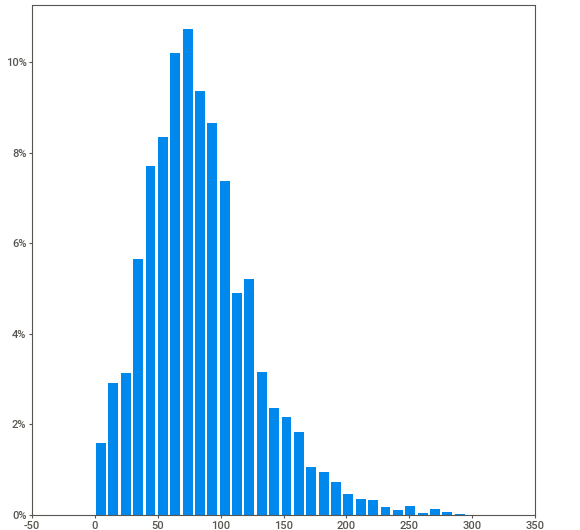
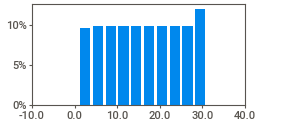
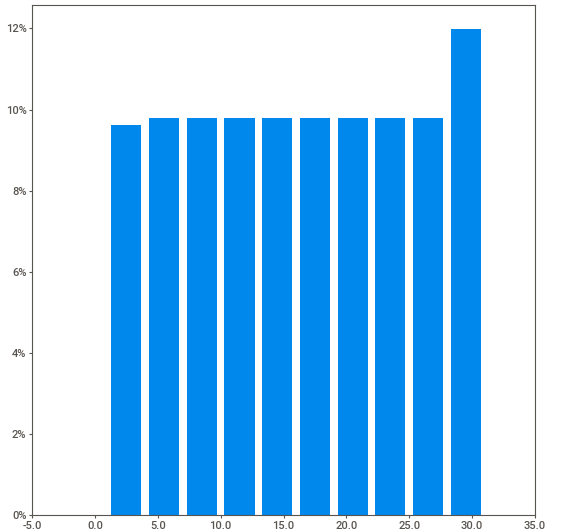
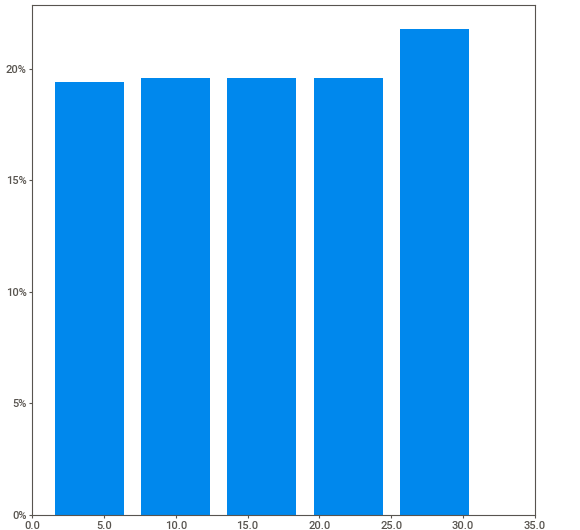
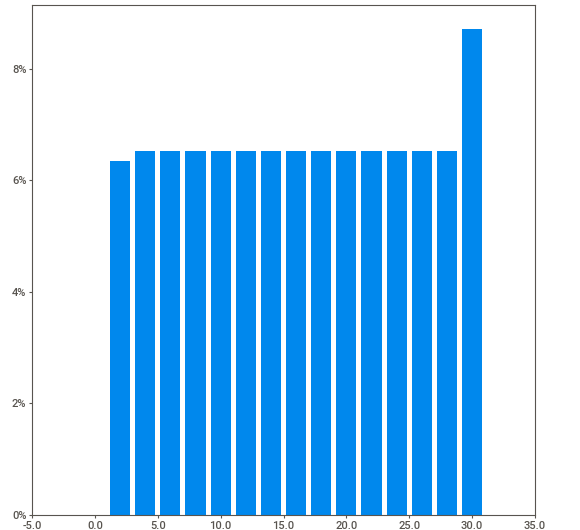
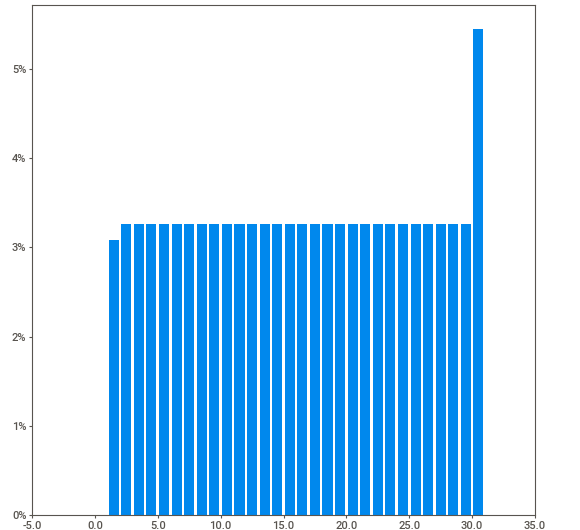
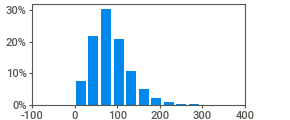
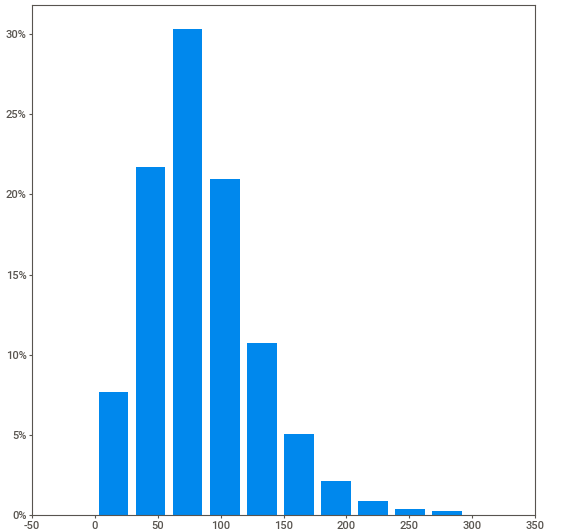
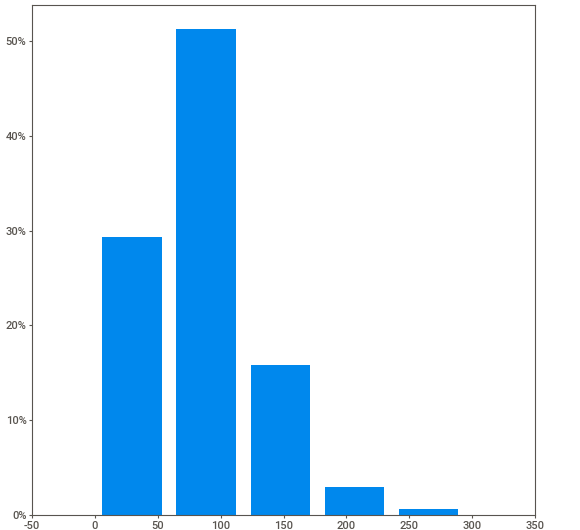
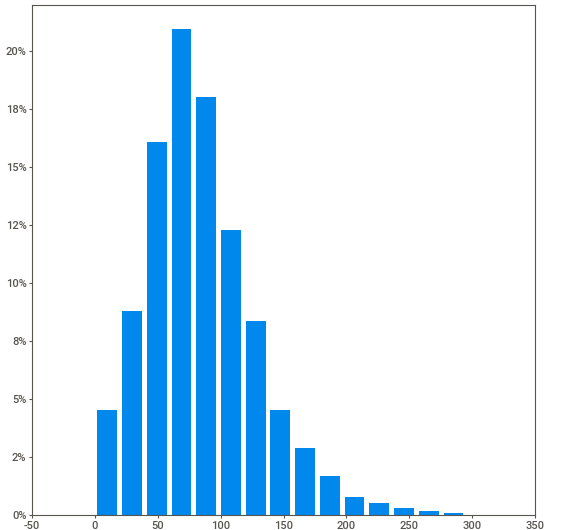
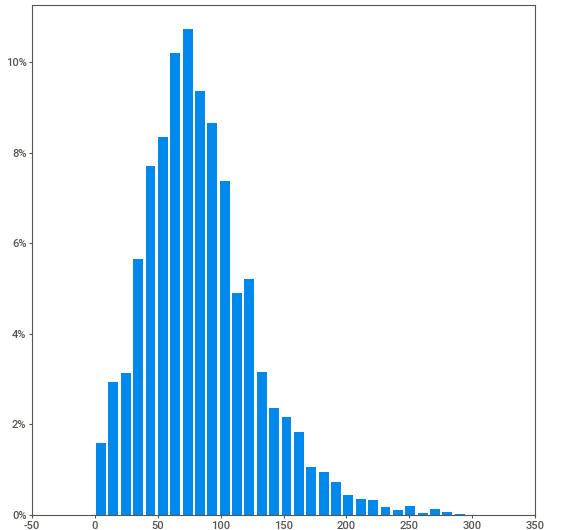
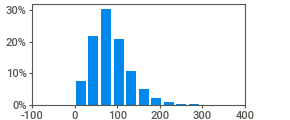
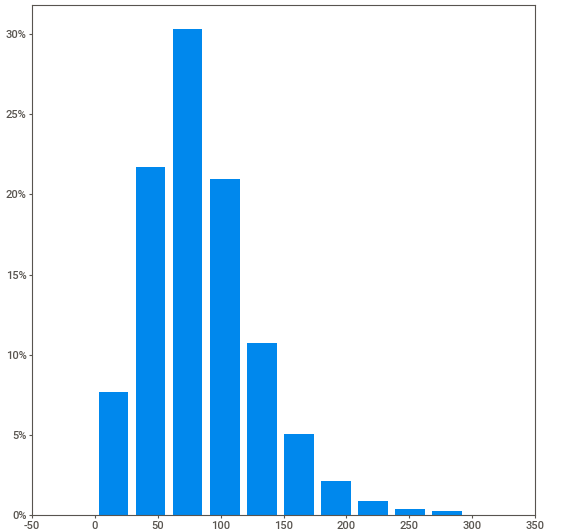
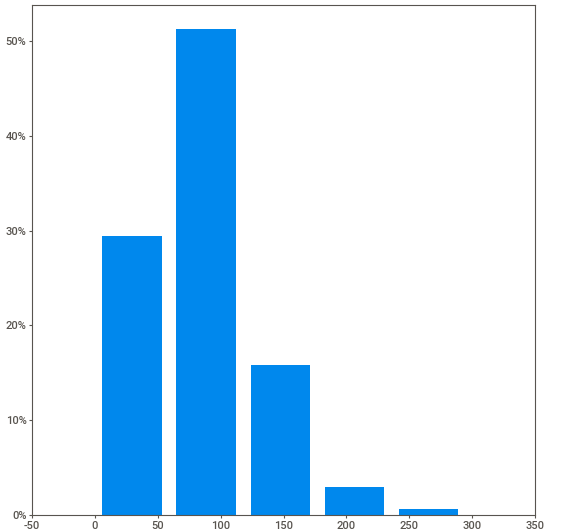
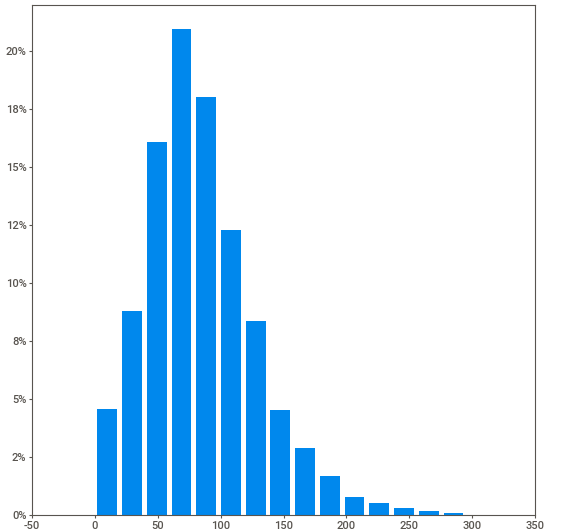
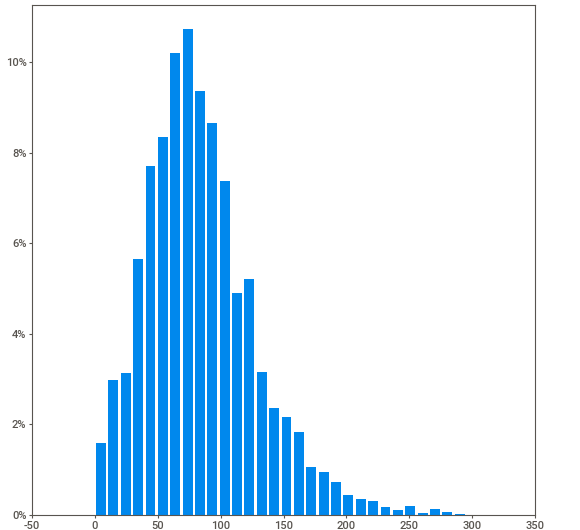
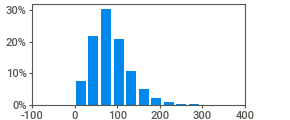
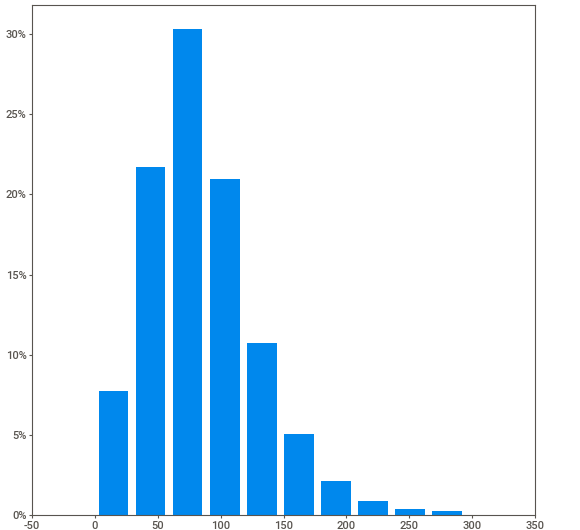
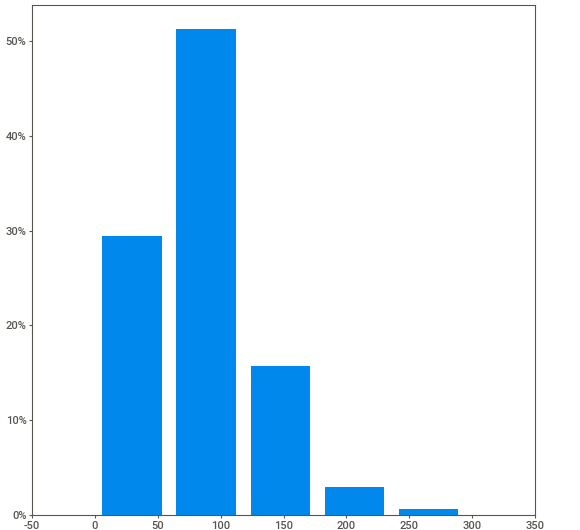
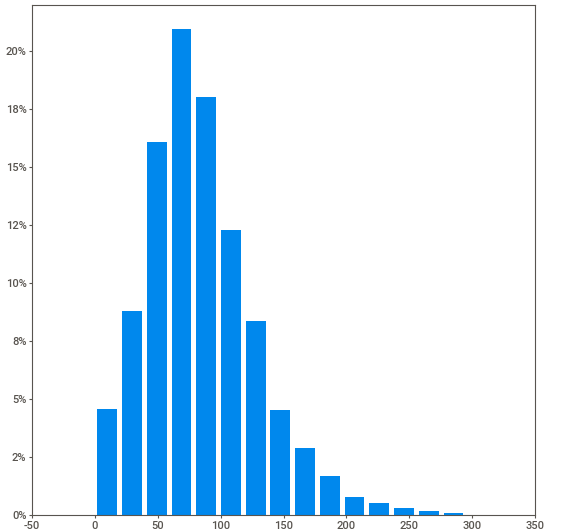
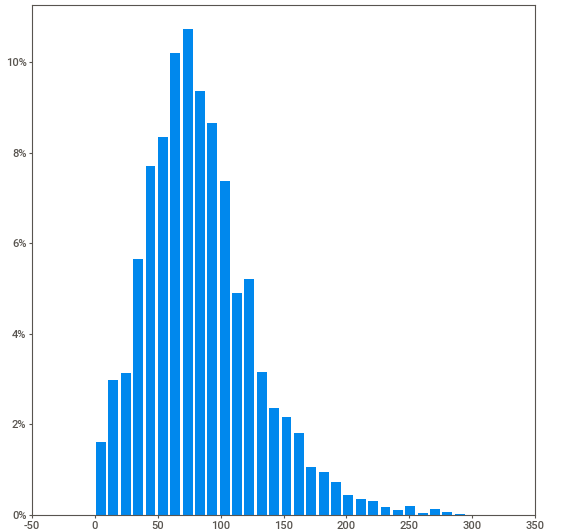
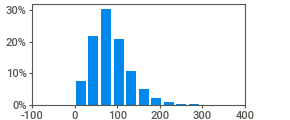
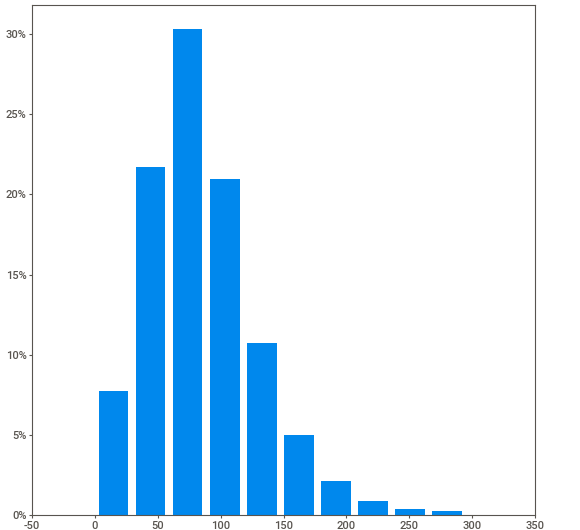
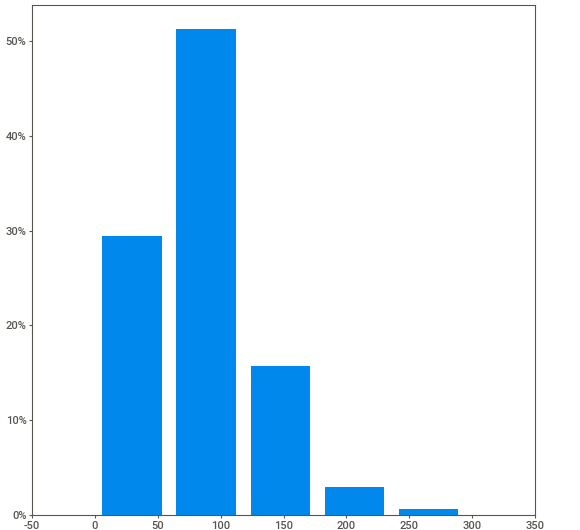
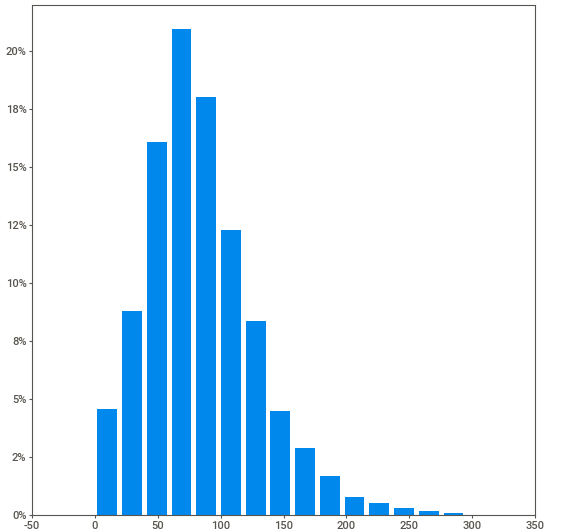
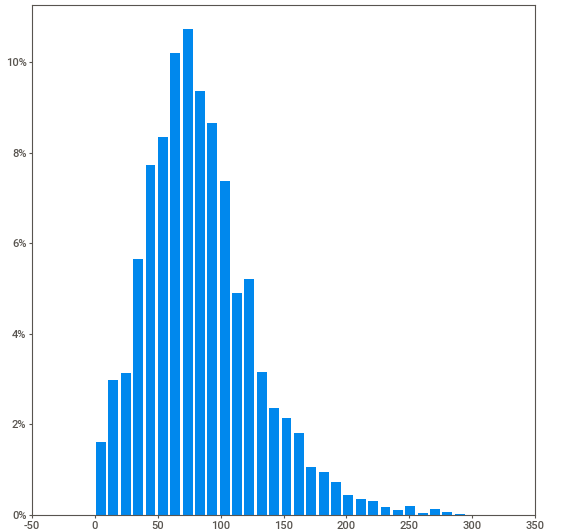
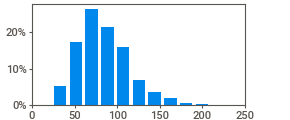
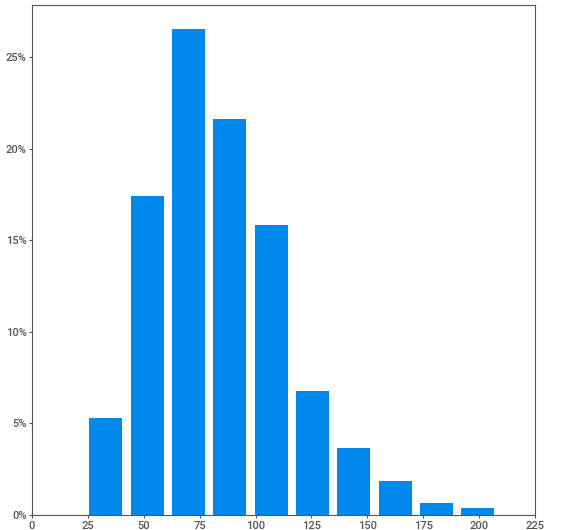
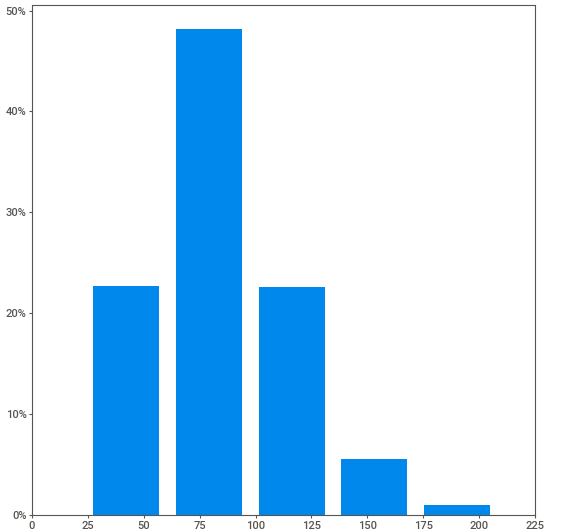
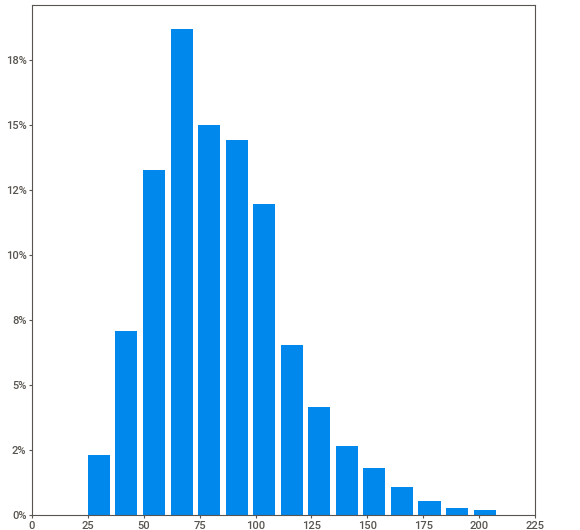
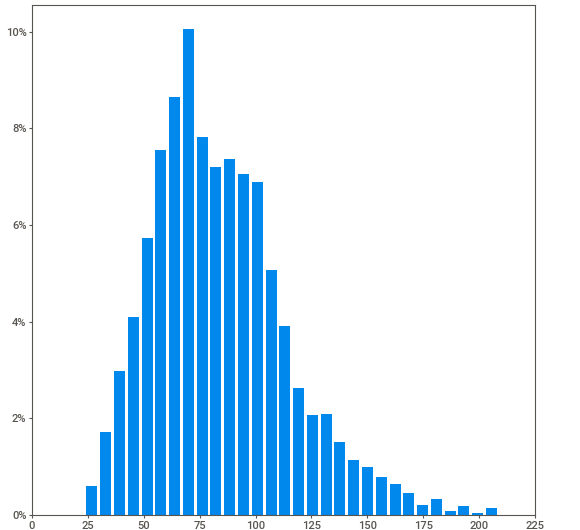
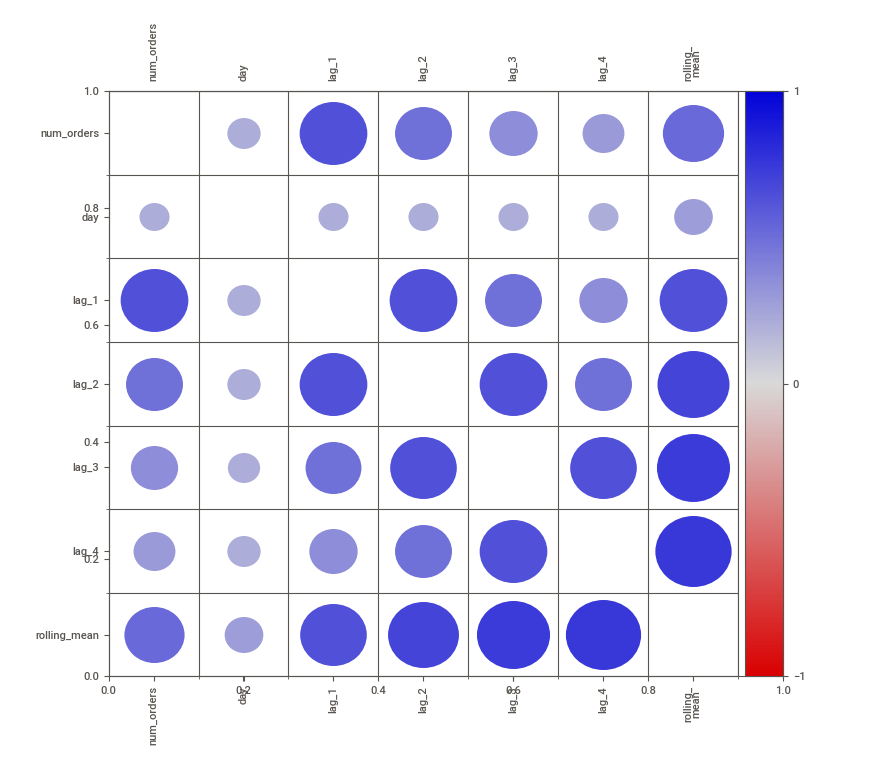
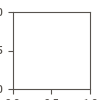

In [23]:

report.show_notebook()


**Вывод**

Заказы распределены по часам не нормальным образом, были выявлены несколько выбросов с количеством зказов в час более 300 - 3 из 4 таких часов были в одно и тоже время с периодом в 1 неделю, выбросы были заменены на средние значения для этих часов.  
анализ ряда на трендовость и сезонность выявил и то и другое, при этом статистические тесты на стационарность разделились: тест ADF показал отсутствие стационарности (но с достаточно близким значением к порогу статзначимости), тест KPSS показал отсутствие стационарности. От трендовости и сезонности решили не избавляться, т.к. это реальные составляющие для прогнозирования значений ряда(временнАя сезонность по часам-пик логична, а тренд может показывать рыночные изменения и  повышение запросов к сервису).  

Для обучения моделией были добавлены дополнительные признаки - по месяцу, дате, дню недели, 4 признака с почасовым лагом(для оценки автокорреляции) и скользящее среднее с 8-часовым окном. Год не был включен признаком, т.к. все данные внутри одного года и единственное значение никак не поможет оценить влияние года на количество заказов.
Матрица корреляции Спирмена показала наличие корреляции целевого признака (num_orders) со всеми признаками кроме дня недели, его было принято решение удалить. среди остальных признаков наибольшая связь целевого признака с месяцем(0.52), предыдущим часом(0.61) и скользящим средним(0.48), осталные признаки имеют менее выраженную связь.

Анализ таблицы признаков с помощью пакета SweetViz дополнительно показал больше специфичных статистик по каждому признаку, подтвердив выводы полученные выше.


<a id='Обучение'></a> 
## Обучение
[К содержанию](#К-содержанию) 

Для начала попробуем обучить несколько простых моделей - линейную регрессию, решающее дерево и более сложный алгоритм градиентного бустинга решающих деревьев.

In [24]:
%%time

# объявим константы
RANDOM_STATE = 42

max_features = len(taxi_h_af.columns)

X = taxi_h_af.drop('num_orders', axis=1) 
y = taxi_h_af['num_orders']

tss = TimeSeriesSplit(n_splits = 4)

CPU times: user 1.1 ms, sys: 620 μs, total: 1.72 ms
Wall time: 1.35 ms


In [25]:
split_index = int(len(X) * 0.9)  # т.к. обучающая выборка 90% от исходной
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [26]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

# задаем наборы гиперпараметрво для перебора
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,20),
        'models__max_features': range(2,max_features+1)
    },

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
    },
    
    # словарь для модели CatBoostRegressor()
    {
        'models': [CatBoostRegressor(silent=True, random_state=RANDOM_STATE)],
        'models__depth': [6,10, 15],
        'models__iterations': [20, 35, 75]
    }
    
]

In [27]:
# полный перебор гиперпараметров с помощью GridSearchCV
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=tss,
    scoring='neg_mean_squared_error',
    n_jobs=-1,

)

model = grid_search.fit(X_train, y_train)

# выгрузим метрику negMSE и преобразуем в RMSE
best_score_neg_mse = model.best_score_
best_score_rmse = round(float(np.sqrt(-best_score_neg_mse)),3)

In [28]:
print(f'Метрика RMSE модели лучшей модели с учетом кросс-валидации: {best_score_rmse}')
print(f'Параметры лучшей модели: {grid_search.best_params_}')

Метрика RMSE модели лучшей модели с учетом кросс-валидации: 33.21
Параметры лучшей модели: {'models': LinearRegression()}


На удивление простая линейная регрессия показала наилучший результат по кросс-валидационным данным (по метрике RMSE - 33.21), для информации посмотрим как справлись остальные модели, возьмем топ-5 лучших моделей из перебора:

In [29]:
res = pd.DataFrame(model.cv_results_)
res=res.sort_values(by='mean_test_score', ascending=False)

res.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__max_depth,param_models__max_features,param_models__depth,param_models__iterations,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
108,0.008462,0.006212,0.002034,0.000717,LinearRegression(),NaN,NaN,NaN,NaN,{'models': LinearRegression()},-769.175360,-949.363010,-1076.798845,-1616.197207,-1102.883606,315.872219,1
10,0.007131,0.000988,0.002713,0.000748,DecisionTreeRegressor(random_state=42),3.0,6.0,NaN,NaN,{'models': DecisionTreeRegressor(random_state=...,-778.568968,-956.905752,-1034.386878,-1731.738879,-1125.400119,362.150625,2
11,0.007419,0.002096,0.002785,0.000731,DecisionTreeRegressor(random_state=42),3.0,7.0,NaN,NaN,{'models': DecisionTreeRegressor(random_state=...,-778.568968,-956.905752,-1034.386878,-1731.738879,-1125.400119,362.150625,2
9,0.007680,0.001964,0.002840,0.000676,DecisionTreeRegressor(random_state=42),3.0,5.0,NaN,NaN,{'models': DecisionTreeRegressor(random_state=...,-776.956667,-952.650105,-1048.316286,-1731.738879,-1127.415484,362.224989,4
15,0.008284,0.000998,0.003062,0.001106,DecisionTreeRegressor(random_state=42),4.0,5.0,NaN,NaN,{'models': DecisionTreeRegressor(random_state=...,-806.412782,-955.056774,-995.456230,-1781.266699,-1134.548121,379.960991,5


In [30]:
%%time

# обучим также специализрованную модель SARIMA, используемую для прогнозирования временных рядов
# т.к. модель напрямую не интегрируется с sklearn- пайплайном сделаем отдельную функцию для кросс-валидации

def cross_validate_sarima(data, order, seasonal_order, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmse_scores = []
    last_model = None

    for train_index, test_index in tscv.split(data):
        train, test = data.iloc[train_index], data.iloc[test_index]
        
        model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
        results = model.fit(disp=False)
            
        forecast = results.get_forecast(steps=len(test))
        forecast_mean = forecast.predicted_mean
        rmse = np.sqrt(mean_squared_error(test, forecast_mean))
        rmse_scores.append(rmse)
        
    return np.mean(rmse_scores),last_model
    

# зададим наборы гиперпараметров: первый кортеж - параметры ARIMA, второй - сезонные параметры
param_sets = [
    ((1, 1, 1), (1, 1, 1, 24)),  # набор 1
    ((0, 1, 1), (0, 1, 1, 24)),  # набор 2
    ((1, 1, 0), (1, 1, 0, 24)),  # набор 3    
]

# запустим кросс-валидацию с перебором гиперпараметров
for param in param_sets:
    average_rmse,last_trained_model = cross_validate_sarima(y_train, param[0], param[1])
    print(f'Средний RMSE для набора параметров {param} : {average_rmse:.3f} \n')

Средний RMSE для набора параметров ((1, 1, 1), (1, 1, 1, 24)) : 28.824 

Средний RMSE для набора параметров ((0, 1, 1), (0, 1, 1, 24)) : 29.579 

Средний RMSE для набора параметров ((1, 1, 0), (1, 1, 0, 24)) : 146.345 

CPU times: user 2min 8s, sys: 4.1 s, total: 2min 12s
Wall time: 2min 13s


Специализированная модель на одном из наборов гиперпараметров улучшила результат по метрике RMSE до 28.824, в таком случае предпочтительнее использовать именно эту модель для проверки на тестовых данных.

**Вывод**

С учетом проведенной кросс-валидаци и подбора гиперпараметров лучшую метрику RMSE 28.824 показала модель **SARIMA** набора параметров ((1, 1, 1), (1, 1, 1, 24)) - ее признаем наиболоее точной и возьмем для тестирования.

<a id='Тестирование'></a> 
## Тестирование
[К содержанию](#К-содержанию) 

Перед тестированием необходимо заново обучить выбранную модель на всем тренировочном датасете (так как при кросс-валидации мы его дробили для подбора гиперпараметров).

In [31]:
best_order = (1, 1, 1)  # лучшие параметры order, найденные на кросс-валидации
best_seasonal_order = (1, 1, 1, 24)  # лучшие сезонные параметры seasonal_order

# обучим модель на всей тренировочной выборке
final_model = SARIMAX(y_train, order=best_order, seasonal_order=best_seasonal_order)
final_model_results = final_model.fit(disp=False)

# делаем прогноз на тестовом наборе данных
forecast = final_model_results.get_forecast(steps=len(y_test))
forecast_mean = forecast.predicted_mean

# считаем метрику на тестовых данных
rmse = np.sqrt(mean_squared_error(y_test, forecast_mean))
print(f'Метрика RMSE на тестовых данных: {rmse:.3f}')

Метрика RMSE на тестовых данных: 35.626


In [32]:
forecast_index = pd.date_range(start=y_train.index[-1], periods=len(y_test)+1, freq='h')[1:]
forecast_series = pd.Series(forecast_mean, index=forecast_index)

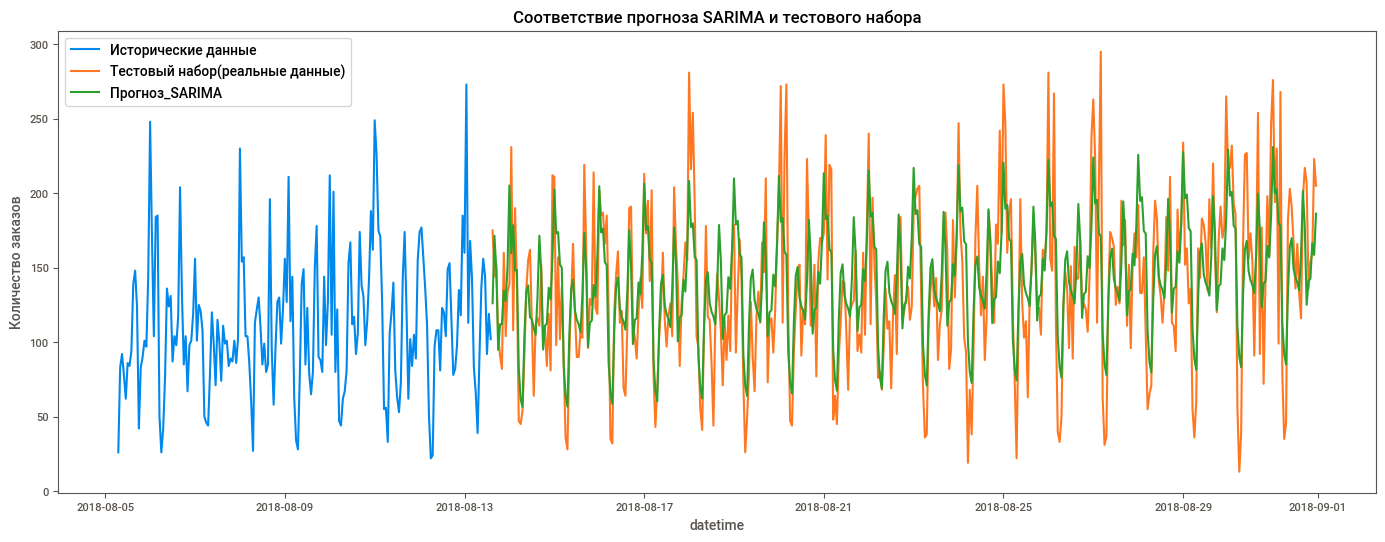

In [33]:
# посмотрим на графиках соответствия моделей тестовым данным
plt.figure(figsize=(17, 6))

plt.title('Соответствие прогноза SARIMA и тестового набора')
sns.lineplot(data=y_train.iloc[-200:],label='Исторические данные')
sns.lineplot(data=y_test, label='Тестовый набор(реальные данные)')
sns.lineplot(data=forecast_series, label='Прогноз_SARIMA')
plt.ylabel('Количество заказов')
plt.legend()
plt.show();

In [34]:
# также проверим модель на адекватность с помощью DummyRegressor
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train,y_train)
y_pred_d = dummy_regr.predict(X_test)

# считаем метрику на тестовых данных
rmse_d = np.sqrt(mean_squared_error(y_test, y_pred_d))
print(f'Метрика RMSE константной модели на тестовых данных: {rmse_d:.3f}')


Метрика RMSE константной модели на тестовых данных: 80.419


**Вывод**  
На тестовом наборе лучшая модель по итогам кросс-валидации SARIMA продемонстрировала достаточный уровень точности (требования задачи - не более 48) по метрике RMSE - 35.626. 
На графике соответствия тестовых данных и прогнозов дополнительно видно, что SARIMA достаточно точно прогнозирует в том числе крайние значения сезонных выбросов.

Для проверки на адекватность была применена константаная модель сгенерированием среднего значения тренировочного датасета, которая показала метрику RMSE 80.419, что более чем в 2 раза хуже основной модели.

<a id='Общий-вывод'></a> 
## Общий вывод
[К содержанию](#К-содержанию) 

После **загрузки** данные были проверены на пропуски, дубликаты, хронологический порядок, а также ресемплированы в часовые промежутки. Данные в ряду представлены за период с 1 марта 2018 по 31 августа 2018. Количество заказов в час колеблется от 0 до 462, со средним 84 заказа.

В результатае **анализа данных** выяснили, что заказы распределены по часам не нормальным образом, были выявлены несколько выбросов с количеством зказов в час более 300 - 3 из 4 таких часов были в одно и тоже время с периодом в 1 неделю, выбросы были заменены на средние значения для соответствующих часов.  
Анализ ряда на трендовость и сезонность выявил и то и другое, при этом статистические тесты на стационарность разделились: тест ADF показал разные оценки возможности отвержения нулевой гипотезы на двух порогах значимости, тест KPSS при оценке для обоих порогов значимости показал отсутствие стационарности, также показал и график скользящего среднего. От трендовости и сезонности решили не избавляться, т.к. это реальные составляющие для прогнозирования значений ряда(временнАя сезонность по часам-пик логична, а тренд может показывать рыночные изменения и повышение запросов к сервису).

Для обучения моделией были добавлены дополнительные признаки - дню месяца, дню недели, 4 признака с почасовым лагом(для оценки автокорреляции) и скользящее среднее с 8-часовым окном. Год и месяц не были включены признаками, т.к. все данные получены в течение одного года и единственное значение никак не поможет оценить влияние года на количество заказов, а месяцы не все присутствуют в данных ряда и модель при обучении на одних месяцах будет некорреткно работать с другими месяцами. Матрица корреляции Спирмена показала наличие корреляции целевого признака (num_orders) со всеми признаками кроме дня недели, было принято решение его удалить. Среди остальных признаков наибольшие связи целевого признака - предыдущим часом(0.61) и скользящим средним(0.48), остальные признаки имеют менее выраженную связь.

Анализ таблицы признаков с помощью пакета SweetViz дополнительно показал больше специфичных статистик по каждому признаку, подтвердив выводы полученные выше.

Для **обучения** было принято решение сначала применить несколько простых моделей - линейную регрессию и решающее дерево, далее уже более сложные алгоритмы градиентного бустинга решающих деревьев и специализированной модели прогнтозирования временных рядов - SARIMA. 
В рамках кросс-валидации с перебором гиперпараметров по первым трем моделям (LinearRegression, DecisionTreeRegression и CatBoost) лдучший результат показала простая линейная регрессия (по метрике RMSE - 33.21), следущей за ней моделью оказалась модель решающего дерева c результатом RMSE - 33.54. Лидером на кросс-валидации стала специализированная модель SARIMA c метрикой RMSE 28.824. Таким образом для тестирования была отобрана модель **SARIMA**.  

На **тестовом наборе** лучшая модель по итогам кросс-валидации **SARIMA** продемонстрировала достаточный уровень точности (требования задачи - не более 48) по метрике **RMSE - 35.626**. Константная модель для проверки на адекватность показала метрику RMSE 80.42.
 На графике соответствия тестовых данных и прогнозов дополнительно видно, что SARIMA достаточно точно прогнозирует в том числе крайние значения сезонных выбросов.